## Bayesian parameter estimation using Importance Sampling

In this notebook we illustrate another way to sample from a posterior pdf, that is, using importance sampling. One samples from a proposal distribution, then the samples are weighted to account for the discrepancy between the proposal pdf and the target posterior pdf. The BayesParameterEstimation class using IS returns samples from the proposal and weigths for each sample. If one requires a set of un-weighted samples, one can use the resample function from UQpy.Utilities. This notebook also illustrates the use of simple diagnostics for IS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate
from UQpy.Utilities import diagnostics

## Probability model

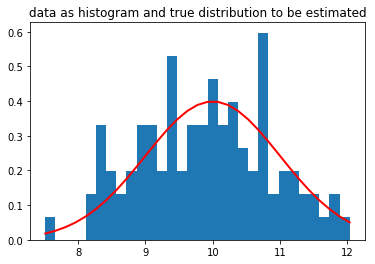

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100).reshape((-1, 1))
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
inference_model = InferenceModel(log_likelihood='normal', n_params=2, prior_name=['uniform','lognormal'], 
                                 prior_params=[[0, 15], [1, 0, 1]])

In [4]:
# Learn the unknown parameters using IS
bayes_estimator = BayesParameterEstimation(inference_model=inference_model, data=data, sampling_method='IS', 
                                           nsamples=10000)

0.9999999999999992


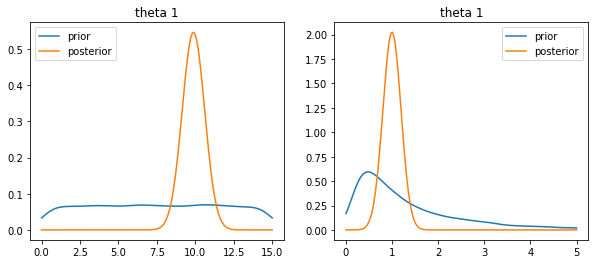

In [5]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2,figsize=(10,4))

domain = np.linspace(0, 15, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].legend()
ax[0].set_title('theta 1')

domain = np.linspace(0, 5, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].legend()
ax[1].set_title('theta 1')

plt.show()

## Regression model - $y=X \theta + \epsilon$

In [6]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
h = RunModel(model_script='pfn_models.py', model_object_name = 'model_quadratic', var_names = ['theta_1', 'theta_2'])
h.run(samples=param_true)
data = h.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  1.31608181  -0.54953355   0.28983913   1.05380684   0.33237614
   1.72230331   5.06001332   4.05507049   9.1297584    7.90407997
   9.99811468  14.36926483  14.80818366  16.36645401  19.68899798
  22.26197032  25.28538433  27.22941059  29.93596622  34.26881009
  35.28213633  41.90020141  44.74139078  47.69450087  53.18647839
  56.00289317  62.32073409  65.34477937  72.56760009  76.38060113
  79.96520487  85.67146051  90.96711664  96.69873741 104.91644125
 108.47870189 114.49612161 121.64063231 127.96578002 134.81503432
 141.13486979 148.0993056  157.12233256 163.62203807 170.61329169
 179.24334031 184.0370473  191.23181811 203.18972351 210.4006464 ]


In [7]:
inference_model = InferenceModel(n_params=2, run_model_object=h, error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, inference_model=inference_model, sampling_method='IS', 
                                           nsamples=200000,
                                           pdf_proposal=['normal','normal'], pdf_proposal_params=[[0, 2], [0, 2]])

0.9999999999999994


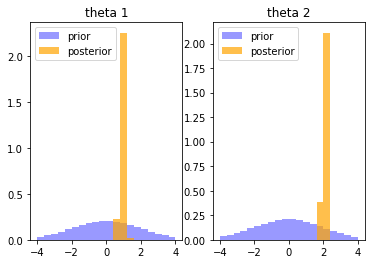

In [9]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(x=s[:,i], weights=None, density=True, range=(-4, 4), bins = 20, color='blue', alpha=0.4, label='prior')
    ax[i].hist(x=s[:,i], weights=w, density=True, range=(-4, 4), bins = 20, color='orange', alpha=0.7, label='posterior')
    ax[i].legend()
    ax[i].set_title('theta {}'.format(i+1))

plt.show()

Diagnostics for Importance Sampling 

Effective sample size is ne=17.09568681970739, out of a total number of samples=200000 

max_weight = 0.12380682033454267, min_weight = 0.0 



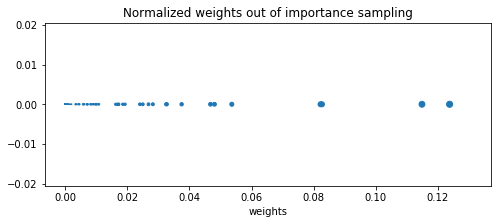

(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1f8c85c0>)

In [10]:
diagnostics(sampling_method='IS', sampling_outputs = bayes_estimator)

In this example, the effective sample size is about 20 samples, out of a total of 20000 samples that were generated and evaluated. A pdf approximation based on 20 samples only is likely to be very poor. Methods to guide the choice of proposal pdf will be released in future versions of UQpy.